Universidade Federal do Rio de Janeiro - UFRJ <br>
Programa de Pós-Graduação em Engenharia de Processos Químicos e Bioquímicos da EQ/UFRJ <br>
Disciplina EQE778 - Aprendizado de Máquina <br>

Atividade Aprendizado Não Supervisionado <br>
Aluno: Francisco Davi Belo Rodrigues

Script de pré-processamento dos dados


In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

In [2]:
# Specify the folder to export the figures
FIGURES_FOLDER = 'figures'

# Specify data and output folders
INPUT_FOLDER = 'input_files'
OUTPUT_FOLDER = 'output_files'

In [3]:
RESULTS_FILE = os.path.join(INPUT_FOLDER, "simulation_results.csv")
df = pd.read_csv(RESULTS_FILE)
df.head(5)

,feedNH3,feedH2S,feedH20,QN1,QN2,QC,SF,H2S_ppm,NH3_ppm
0,0.001,0.001,0.998,450000.0,700000.0,3.0,0.090909,0.000313,0.714132
1,0.001,0.001,0.998,450000.0,700000.0,3.0,0.181818,0.010239,2.507203
2,0.001,0.001,0.998,450000.0,700000.0,3.0,0.272727,0.645766,18.451377
3,0.001,0.001,0.998,450000.0,700000.0,3.0,0.363636,0.294084,11.326070
4,0.001,0.001,0.998,450000.0,700000.0,3.0,0.454545,0.831464,19.566638


In [4]:
print('Data rows:', df.shape[0])

Data rows: 897255


In [5]:
# Observing data tail
df.tail(5)

,feedNH3,feedH2S,feedH20,QN1,QN2,QC,SF,H2S_ppm,NH3_ppm
897250,0.0091,0.0037,0.9872,480000.0,980000.0,3.0,0.000000,0.157615,8.449645
897251,0.0082,0.0037,0.9881,500000.0,870000.0,3.0,0.454545,0.067897,5.320042
897252,0.0082,0.0046,0.9872,510000.0,1030000.0,3.0,0.636364,0.061325,5.334185
897253,0.0082,0.0037,0.9881,580000.0,1170000.0,3.0,0.454545,0.049253,4.881684
897254,0.0091,0.0064,0.9845,460000.0,900000.0,3.0,0.818182,3.981980,59.276283


In [6]:
# Observing a sample
SAMPLE_SIZE = 5
start = np.random.randint(0, len(df) - SAMPLE_SIZE + 1)
sample_df = df.iloc[start : start + SAMPLE_SIZE]

sample_df.head(SAMPLE_SIZE)

,feedNH3,feedH2S,feedH20,QN1,QN2,QC,SF,H2S_ppm,NH3_ppm
500239,0.0064,0.0019,0.9917,520000.0,1040000.0,3.0,0.090909,0.766347,21.349341
500240,0.0055,0.0073,0.9872,540000.0,790000.0,3.0,0.636364,5.393407,68.870372
500241,0.0055,0.0082,0.9863,470000.0,980000.0,3.0,0.363636,1.661095,31.303708
500242,0.0064,0.0091,0.9845,590000.0,1190000.0,3.0,0.090909,0.034772,5.803387
500243,0.0055,0.0046,0.9899,550000.0,1170000.0,3.0,0.090909,0.047978,6.681842


In [7]:
df.describe()

,feedNH3,feedH2S,feedH20,QN1,QN2,QC,SF,H2S_ppm,NH3_ppm
count,897254.000000,897255.000000,897255.000000,897255.000000,8.972550e+05,897255.0,897255.000000,8.972550e+05,8.972550e+05
mean,0.005049,0.005050,0.989901,524999.860686,9.499940e+05,3.0,0.454533,4.364661e+03,8.060725e+01
std,0.002585,0.002585,0.003656,46098.094915,1.471950e+05,0.0,0.287474,1.372127e+04,5.628852e+03
min,0.001000,0.001000,0.981800,450000.000000,7.000000e+05,3.0,0.000000,1.634596e-30,3.719056e-32
25%,0.002800,0.002800,0.987200,480000.000000,8.200000e+05,3.0,0.181818,4.148268e-01,2.394929e-03
50%,0.004600,0.005500,0.989900,530000.000000,9.500000e+05,3.0,0.454545,1.660825e+03,6.077546e+00
75%,0.007300,0.007300,0.992600,570000.000000,1.080000e+06,3.0,0.727273,7.546250e+03,2.247266e+01
max,0.009100,0.009100,0.998000,600000.000000,1.200000e+06,3.0,0.909091,1.000000e+06,1.000000e+06


In [8]:
# Check for NaN values
nan_check = df.isna().sum()
print("NaN values per column:\n", nan_check)

# Check for zero values
zero_check = (df == 0).sum()
print("\nZero values per column:\n", zero_check)


NaN values per column:
 feedNH3    1
feedH2S    0
feedH20    0
QN1        0
QN2        0
QC         0
SF         0
H2S_ppm    0
NH3_ppm    0
dtype: int64

Zero values per column:
 feedNH3        0
feedH2S        0
feedH20        0
QN1            0
QN2            0
QC             0
SF         81564
H2S_ppm        0
NH3_ppm        0
dtype: int64


In [9]:
# Filter rows with NaN values
nan_rows = df[df.isna().any(axis=1)]
print("Rows with NaN values:\n", nan_rows)


Rows with NaN values:
         feedNH3  feedH2S  feedH20       QN1       QN2   QC        SF  \
152531      NaN   0.0019   0.9962  510000.0  730000.0  3.0  0.181818   

         H2S_ppm    NH3_ppm  
152531  1.482682  29.982455  


In [10]:
# Drop rows with any NaN values
df = df.dropna()

# Optionally, reset the index if needed
df = df.reset_index(drop=True)

# Check for NaN values
nan_check = df.isna().sum()
print("NaN values per column:\n", nan_check)

NaN values per column:
 feedNH3    0
feedH2S    0
feedH20    0
QN1        0
QN2        0
QC         0
SF         0
H2S_ppm    0
NH3_ppm    0
dtype: int64


In [11]:
# Drop columns
df = df.drop(columns=['QC', 'feedH20'])
df.head()

,feedNH3,feedH2S,QN1,QN2,SF,H2S_ppm,NH3_ppm
0,0.001,0.001,450000.0,700000.0,0.090909,0.000313,0.714132
1,0.001,0.001,450000.0,700000.0,0.181818,0.010239,2.507203
2,0.001,0.001,450000.0,700000.0,0.272727,0.645766,18.451377
3,0.001,0.001,450000.0,700000.0,0.363636,0.294084,11.326070
4,0.001,0.001,450000.0,700000.0,0.454545,0.831464,19.566638


In [12]:
# Applying the rule to transform the last two columns into binary values
df['H2S_binary'] = df['H2S_ppm'] >= 0.2
df['NH3_binary'] = df['NH3_ppm'] >= 15
df['H2S_binary'] = df['H2S_binary'].astype(int)
df['NH3_binary'] = df['NH3_binary'].astype(int)
df.head()

,feedNH3,feedH2S,QN1,QN2,SF,H2S_ppm,NH3_ppm,H2S_binary,NH3_binary
0,0.001,0.001,450000.0,700000.0,0.090909,0.000313,0.714132,0,0
1,0.001,0.001,450000.0,700000.0,0.181818,0.010239,2.507203,0,0
2,0.001,0.001,450000.0,700000.0,0.272727,0.645766,18.451377,1,1
3,0.001,0.001,450000.0,700000.0,0.363636,0.294084,11.326070,1,0
4,0.001,0.001,450000.0,700000.0,0.454545,0.831464,19.566638,1,1


In [13]:
# Drop columns
df = df.drop(columns=['H2S_ppm', 'NH3_ppm'])
df.head()

,feedNH3,feedH2S,QN1,QN2,SF,H2S_binary,NH3_binary
0,0.001,0.001,450000.0,700000.0,0.090909,0,0
1,0.001,0.001,450000.0,700000.0,0.181818,0,0
2,0.001,0.001,450000.0,700000.0,0.272727,1,1
3,0.001,0.001,450000.0,700000.0,0.363636,1,0
4,0.001,0.001,450000.0,700000.0,0.454545,1,1


In [14]:
# Separate features and labels from original df first
df2_x = df.iloc[:, :-2]  # All columns except last two
df2_bin_y = df.iloc[:, -2:]  # Only last two columns

scaler2_x = PowerTransformer()

df2_scaled_x = pd.DataFrame(scaler2_x.fit_transform(df2_x), 
                            columns=df2_x.columns, 
                            index=df2_x.index)

df2_scaled = df2_scaled_x.join(df2_bin_y)
print("Scaled DataFrames created successfully!")

Scaled DataFrames created successfully!


In [15]:
# Export the scaled dataframe using joblib
joblib.dump(df2_scaled_x, os.path.join(INPUT_FOLDER, 'df2_scaled_x.joblib'))
joblib.dump(df2_bin_y, os.path.join(INPUT_FOLDER, 'df2_bin_y.joblib'))

# Export the scalers using joblib
joblib.dump(scaler2_x, os.path.join(INPUT_FOLDER, 'scaler2_x.joblib'))

# Export column names
joblib.dump(df2_scaled_x.columns, os.path.join(INPUT_FOLDER, 'df2_scaled_x_columns.joblib'))
joblib.dump(df2_bin_y.columns, os.path.join(INPUT_FOLDER, 'df2_bin_y_columns.joblib'))
print("Data and scalers exported successfully to the input files folder!")

Data and scalers exported successfully to the input files folder!


Foram criados gráficos de histogramas para todas as variáveis com o objetivo de avaliar se os dados estavam razoavelmente completos para o espaço que se desejava modelar ou se existiam possíveis lacunas.

Conforme observado, os dados estão bem distribuídos, apresentando frequências equilibradas na maioria das variáveis. A única exceção é a variável QN2, que apresenta frequências menores em valores intermediários, indicando uma possível lacuna nesta região.

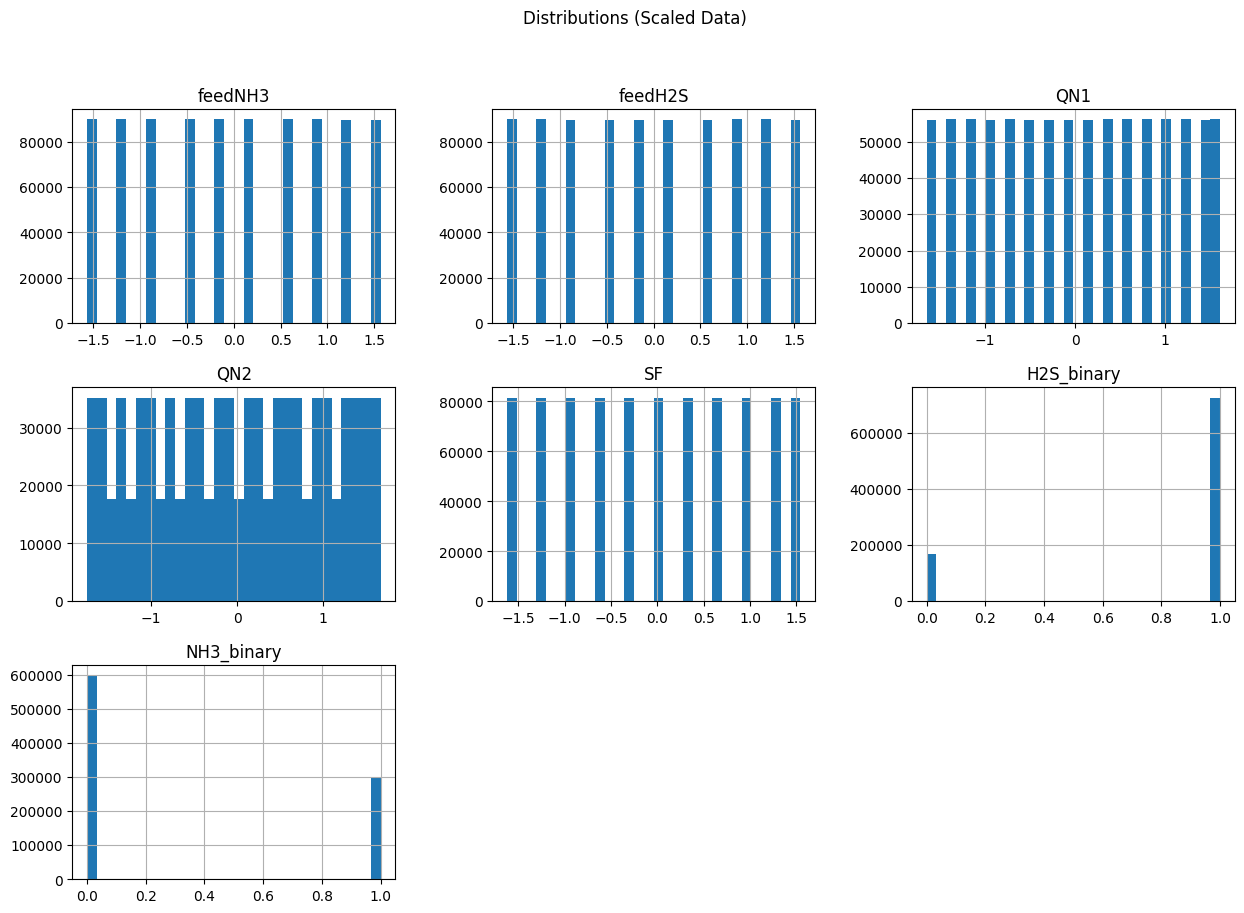

In [16]:
# Data Distribution and Descriptive Statistics
# Histograms for each feature in df_scaled
df2_scaled.hist(bins=30, figsize=(15, 10))
plt.suptitle("Distributions (Scaled Data)")
plt.show()

Foram criados gráficos abaixo do tipo box plot para avaliar a presença de outliers nos dados.
Os dados não apresentaram outliers

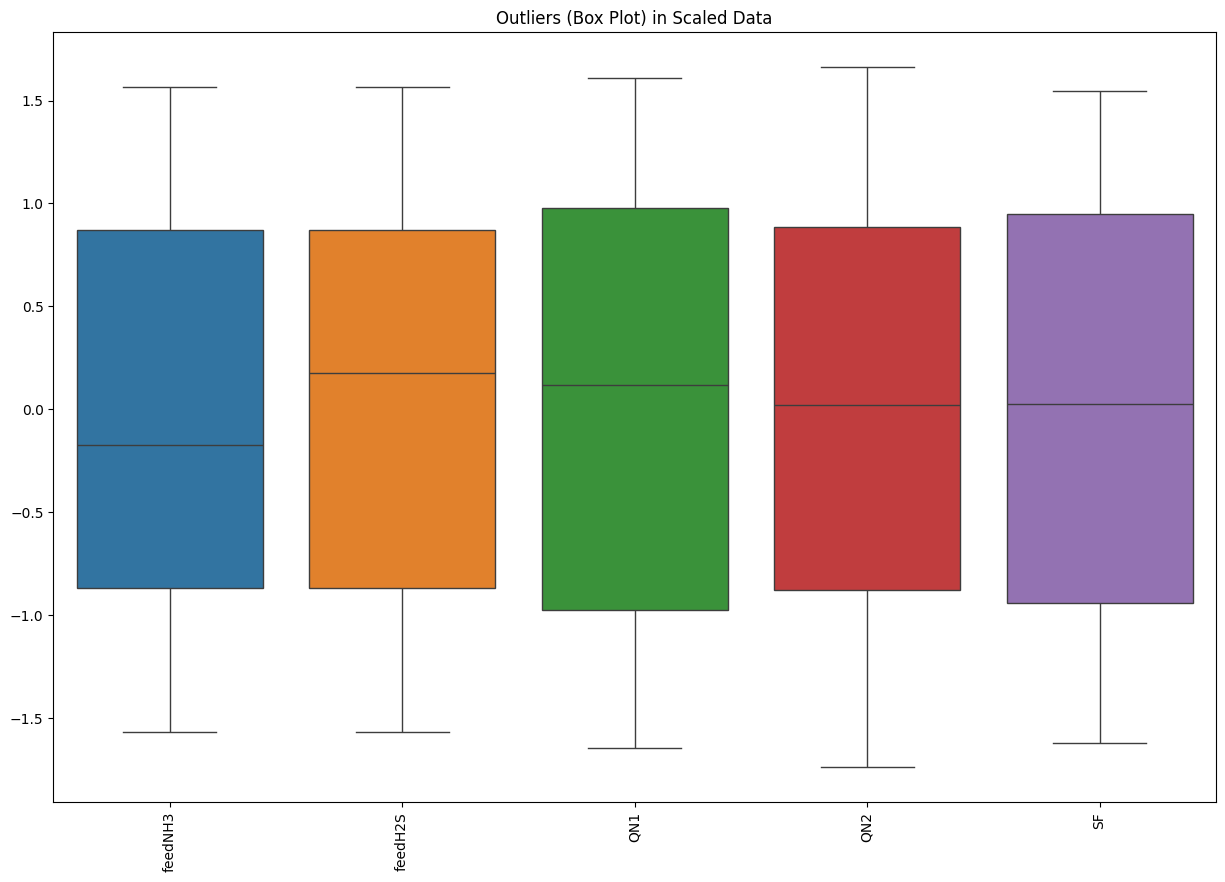

In [17]:
# Box plots to check for outliers in df_scaled
plt.figure(figsize=(15, 10))
sns.boxplot(data=df2_scaled_x)
plt.xticks(rotation=90)
plt.title("Outliers (Box Plot) in Scaled Data")
plt.show()

Foi criado um pair plot com o objetivo de aprofundar a análise dos dados.

Na diagonal, as distribuições uniformes das variáveis de entrada indicam que o espaço dos dados está bem coberto, o que é positivo para o treinamento do modelo.

Já nos gráficos de dispersão, observa-se pouca ou nenhuma correlação linear evidente entre as variáveis de entrada, sugerindo que as relações entre elas podem ser mais complexas ou não lineares.

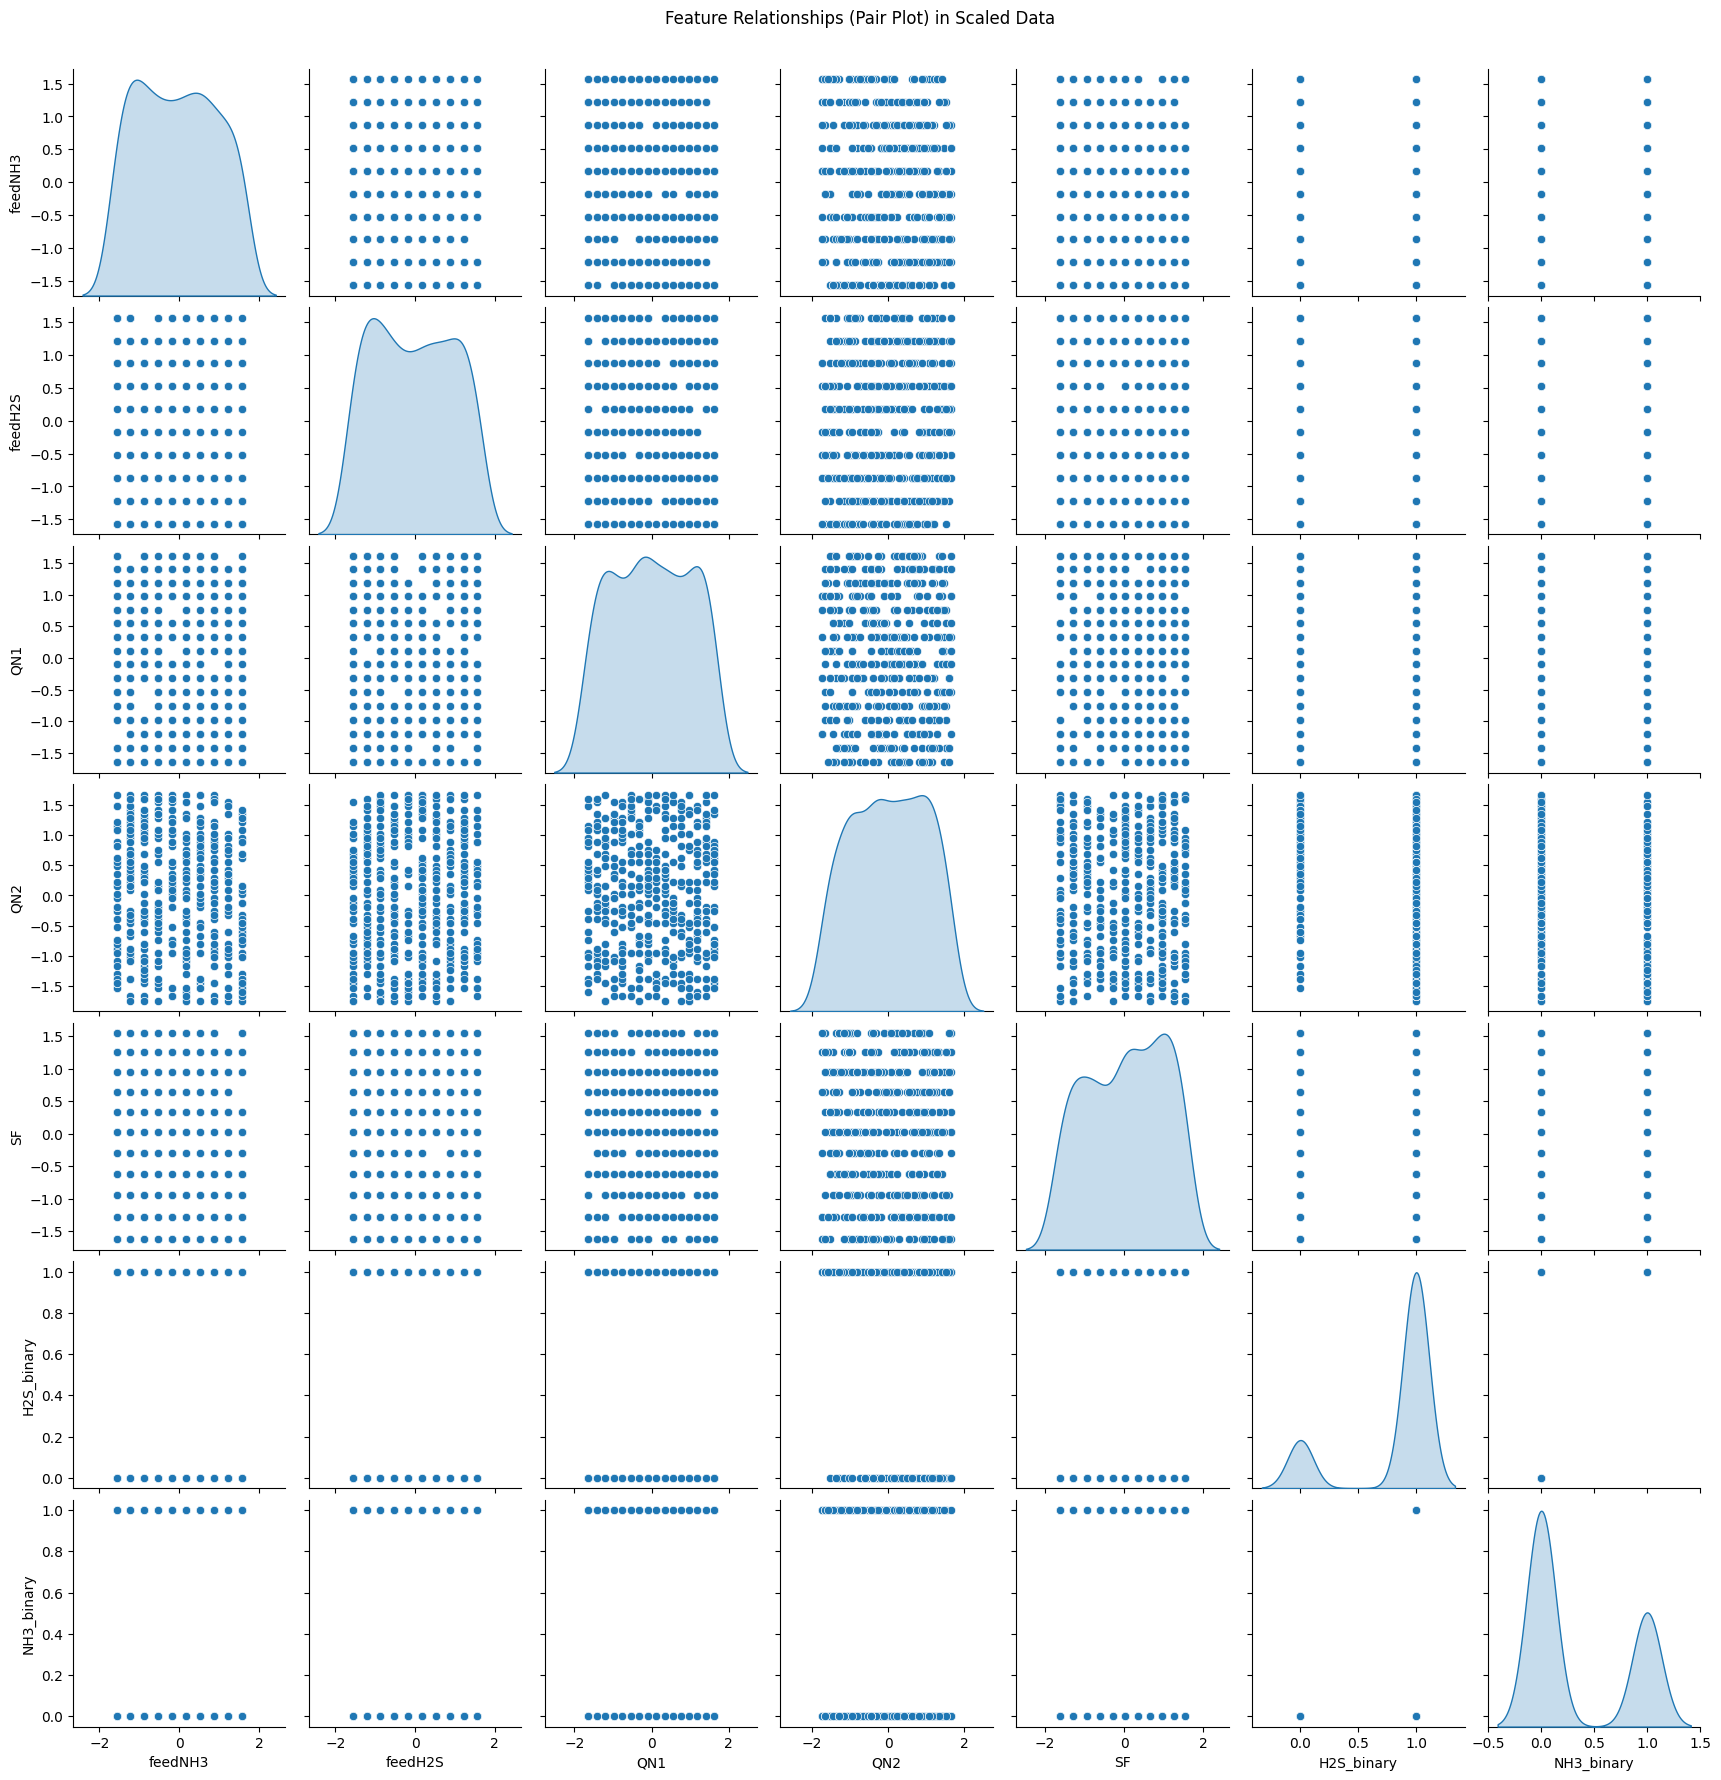

In [18]:
# Pair Plot (if data size is manageable)
sns.pairplot(df2_scaled.sample(n=min(500, len(df2_scaled))), diag_kind='kde')
plt.suptitle("Feature Relationships (Pair Plot) in Scaled Data", y=1.02)
plt.show()

Abaixo, foi gerada uma matriz de correlação, confirmando que as variáveis escolhidas para entrada do modelo possuem correlação praticamente nula entre si.

A matriz também demonstra correlações consistentes e coerentes entre as variáveis de entrada e as variáveis de saída. Para as variáveis de saída, considera-se que 1 indica contaminante acima da especificação na água tratada.

Com base nos resultados, foram identificadas as seguintes relações:

Quanto maior a concentração de contaminantes na carga (feedH2S, feedNH3), maior a quantidade de contaminantes na água tratada.
Quanto maiores as cargas térmicas nas torres 1 e 2 (QN1 e QN2), menor a quantidade de contaminantes na água tratada.
Quanto maior o desvio na recuperação de calor (SF), maior a quantidade de contaminantes na água tratada.

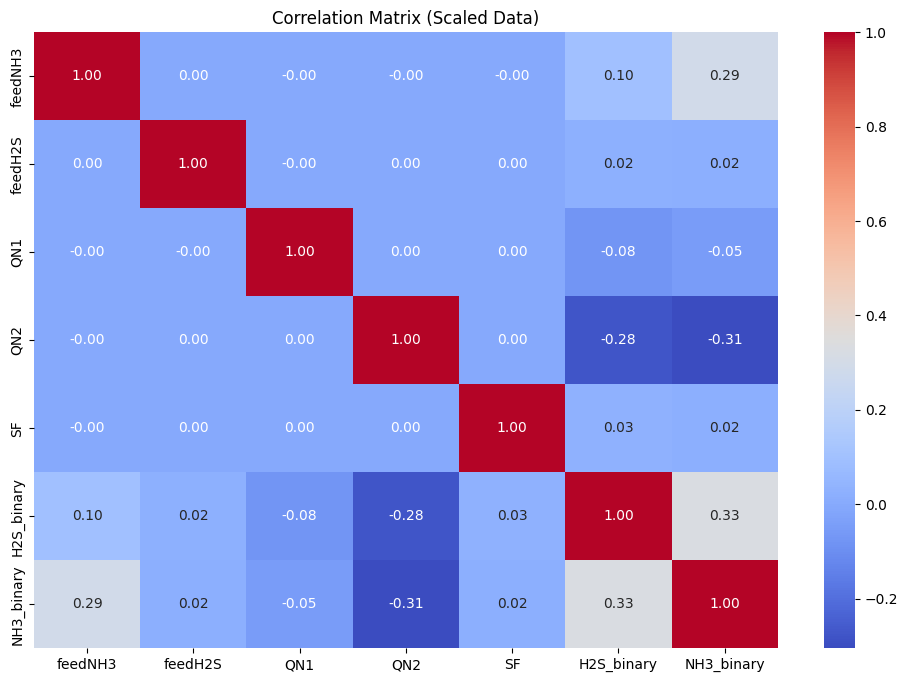

In [19]:
# Correlation Analysis
# Heatmap for Correlation Matrix in df_scaled
plt.figure(figsize=(12, 8))
sns.heatmap(df2_scaled.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (Scaled Data)")
plt.show()

Foi realizada uma pré-modelagem utilizando Random Forest para avaliar a relevância das variáveis de entrada (features).

Como pode-se observar, todas as cinco variáveis apresentaram relevância, ou seja, possuem importância estatística para explicar a variabilidade das saídas.

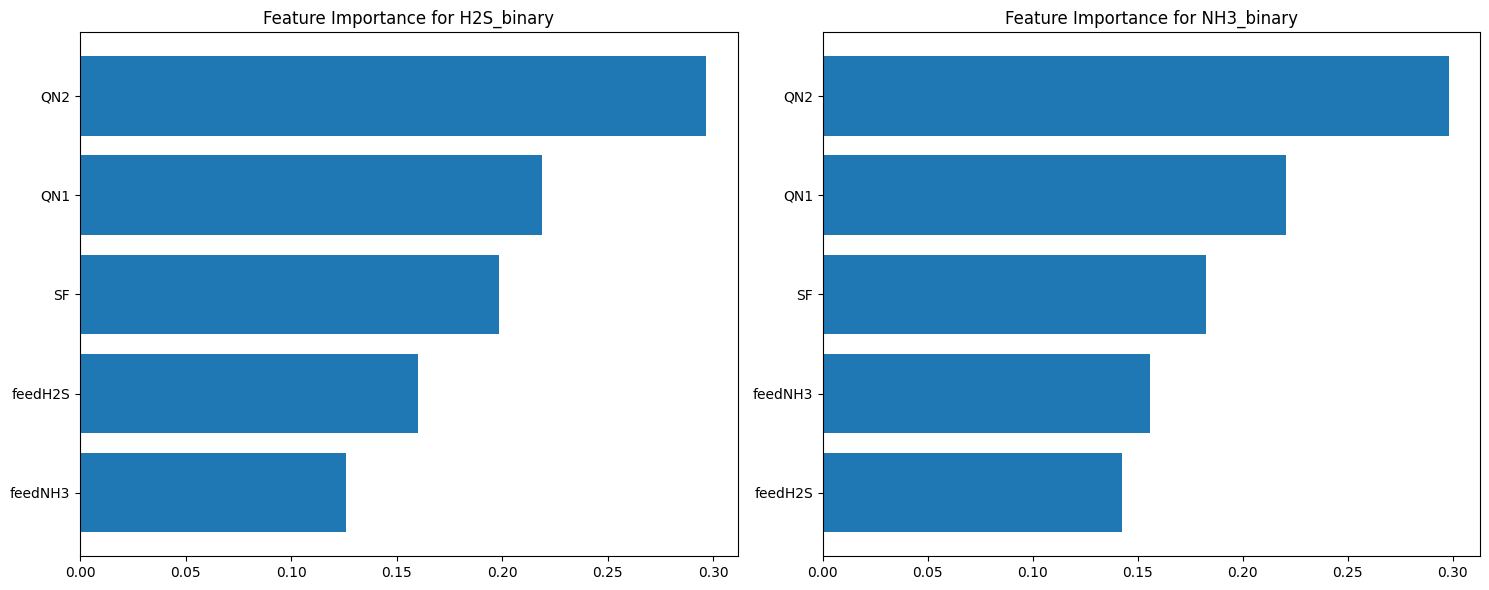


feedNH3:
H2S_binary: 0.1259
NH3_binary: 0.1559

feedH2S:
H2S_binary: 0.1602
NH3_binary: 0.1426

QN1:
H2S_binary: 0.2187
NH3_binary: 0.2208

QN2:
H2S_binary: 0.2966
NH3_binary: 0.2982

SF:
H2S_binary: 0.1986
NH3_binary: 0.1825


In [20]:
# Create and fit model
multi_model = MultiOutputRegressor(RandomForestRegressor(random_state=42, n_jobs=-1))
multi_model.fit(df2_scaled_x, df2_bin_y)

# Create plot
plt.figure(figsize=(15, 6))

# Plot for each target
for i, (estimator, target_name) in enumerate(zip(multi_model.estimators_, df2_bin_y.columns)):
    plt.subplot(1, 2, i+1)
    sorted_idx = np.argsort(estimator.feature_importances_)
    plt.barh(df2_scaled_x.columns[sorted_idx], estimator.feature_importances_[sorted_idx])
    plt.title(f"Feature Importance for {target_name}")

plt.tight_layout()
plt.show()

# Print values if needed
for feature in df2_scaled_x.columns:
    print(f"\n{feature}:")
    for i, target_name in enumerate(df2_bin_y.columns):
        print(f"{target_name}: {multi_model.estimators_[i].feature_importances_[df2_scaled_x.columns.get_loc(feature)]:.4f}")

In [21]:
# # Visualizing High-Dimensional Data with t-SNE
# # Using t-SNE to reduce features to 2 dimensions for visualization
# tsne = TSNE(n_components=2, random_state=42)
# x_tsne = tsne.fit_transform(df2_scaled_x)

# # Plot t-SNE result, coloring points by the mean of the target values in df2_bin_y
# plt.figure(figsize=(10, 8))
# plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=df2_bin_y.mean(axis=1), cmap="viridis", alpha=0.7)
# plt.colorbar(label='Mean Target Value (Scaled Data)')
# plt.title("t-SNE Visualization of Scaled Features (Colored by Mean Target Value)")
# plt.show()

Foi aplicada a técnica de PCA para transformar o espaço das variáveis. Contudo, mesmo após a transformação, observa-se que o número de variáveis permaneceu em cinco, com a variância explicada distribuída de forma praticamente igual entre todas elas.

Dessa forma, conclui-se que não foi possível, nem seria interessante, eliminar alguma variável para reduzir a dimensionalidade do problema, pois todas contribuem de maneira equivalente para a representação dos dados.

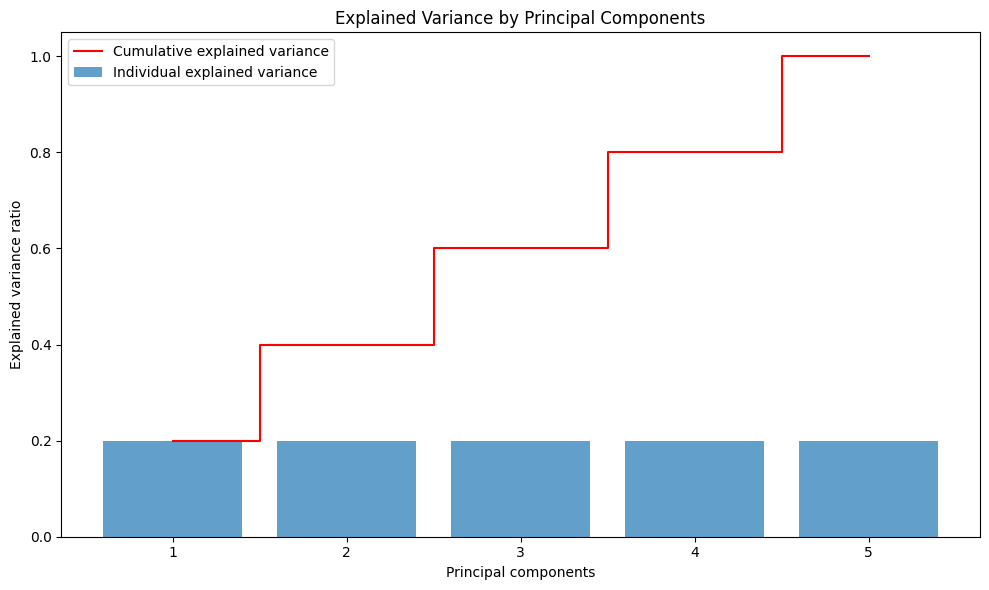

Number of components explaining 95% of variance: 5


In [22]:

# Ensure the data is a NumPy array (if it's not already)
x_data = df2_scaled_x.values
y_data = df2_bin_y['H2S_binary'].values  # Use one binary label, e.g., 'H2S_binary'

# Perform PCA
pca = PCA()
pca_results = pca.fit_transform(x_data)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label='Individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance', color='red')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('Explained Variance by Principal Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Select the top components explaining 95% of variance
num_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components explaining 95% of variance: {num_components}")

# Project data to the selected components
x_pca = pca_results[:, :num_components]

# Convert back to a DataFrame for analysis
columns = [f"PC{i + 1}" for i in range(num_components)]
pca_df = pd.DataFrame(x_pca, columns=columns)
pca_df['binary_label'] = y_data

# # Visualize the first two principal components
# plt.figure(figsize=(10, 6))
# plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['binary_label'], cmap='viridis', edgecolor='k', alpha=0.7)
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('PCA: First Two Principal Components')
# plt.colorbar(label='Binary Label')
# plt.tight_layout()
# plt.show()